In [1]:
import matplotlib
import imageio
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy import signal
import numpy as np 
import pandas as pd

In [2]:
import os
import re 

files = {os.path.splitext(k)[0]: {} for k in os.listdir('../Practica3/data') if 'acero' in os.path.splitext(k)[0] or 'laton' in os.path.splitext(k)[0]}


for i,file in enumerate(os.listdir('../Practica3/data')):
    name = os.path.splitext(file)[0]
    if 'acero' in name or 'laton' in name:
        f = open(f'../Practica3/data/{file}').read().split()[7:]
        t = [float(f[i]) for i in range(0,len(f),2)]
        v = [float(f[i + 1]) for i in range(0,len(f),2)]
        files[name]['t'] = np.array(t)
        files[name]['v'] = np.array(v)

  

### Acero 3

In [132]:
t = files['acero_3']['t'][1000:]
v = files['acero_3']['v'][1000:]
# arreglo un poco
v = v - np.median(v) #corro el 0
t= np.linspace(0, len(t)/1000, len(t))

Text(0, 0.5, 'Signal [V]')

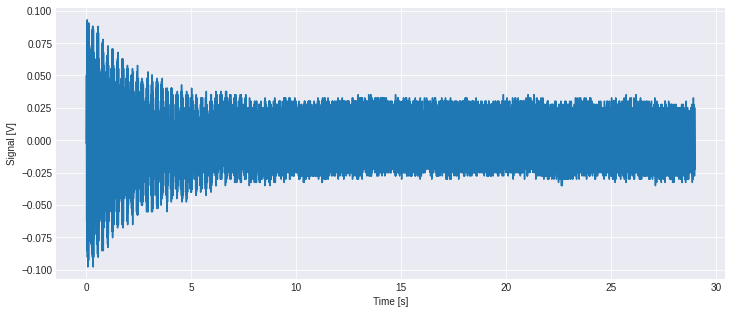

In [133]:
%matplotlib inline
from scipy.signal import find_peaks
plt.figure(figsize = (12,5))
plt.clf()
plt.plot(t,v)
plt.xlabel("Time [s]")
plt.ylabel("Signal [V]")

Primero vemos qué tipo de ruido es (blanco, rosa), para ver cómo aproximar la frecuencias de modulación

Dos métodos distintos de PSD. PROBARLOS

https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.butter.html

https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.signal.bessel.html

In [134]:
import seaborn as sns
plt.style.use('seaborn-darkgrid')

In [135]:
### Defino variables temporales de la medición.
Fs = 1/t[1]           #[Hz] Frecuencia de muestreo                    
FRef = 54         #[Hz] Frecuencia de la referencia: la sacamos del informe
L = len(v);     #[muestras] Longitud de la señal
# Calculamos variables asociadas 
T = 1/Fs;              #[s] Periodo de muestreo
MaxT = L/Fs;           #[s] Tiempo maximo
t = np.linspace(0,L-1,L)*T;         #[s] Time vector
OmegaRef = FRef*2*np.pi;     #[rad/s] frecuencia angular de referencia


#Genero las señales de referencia del lock-in.
Referencia_x=np.array(np.sin(OmegaRef*t));
Referencia_y=np.array(np.cos(OmegaRef*t)); #referencia desfasada en 90º

Muestro la señal del laton en el espacio de frecuencias para ver bien qué otras frecuencias afectan mi medicion

(1.0, 135.0)

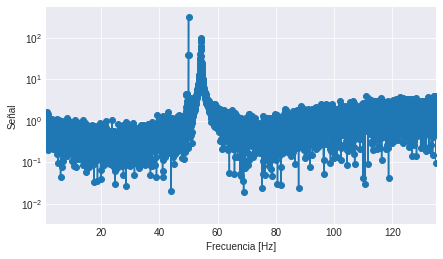

In [136]:
#%% Demodulación lock-in.

# Generamos una figura
plt.figure(figsize=(7,4))
plt.clf()
# Armamos el vector de frecuencias.
freqs=np.fft.fftfreq(L,1/Fs)

# 1 Grafica la FFT de la referencia
fftReferencia= np.abs(np.fft.fft(Referencia_x));
fftSenial= np.abs(np.fft.fft(v));
plt.semilogy(freqs[0:L//2],fftSenial[0:L//2],'o-') 
plt.ylabel('Señal')
plt.xlabel('Frecuencia [Hz]')
plt.xlim([1,2.5*FRef])


Vemos qué PSD nos da en el tiempo y en elespacio de frecuencia para saber qué frecuencia de corte tomar y qué orden de filtro

(1.0, 135.0)

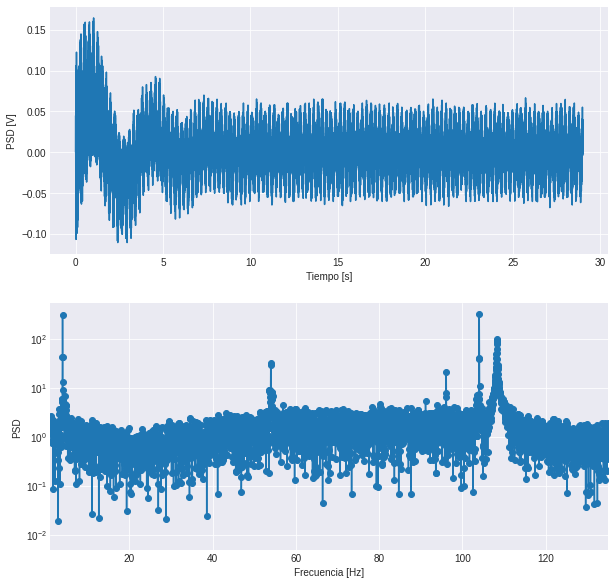

In [137]:
plt.figure(figsize=(10,10))
plt.clf()
fig, ax = plt.subplots(2,1,num=1)

# Detección de fase. Multiplicación por referencia
PSDx = 2 * v * Referencia_x;
PSDy = 2 * v * Referencia_y; #PSD del segundo canal
# Graficamos señal multiplicada
ax[0].plot(t, PSDx, label='Señal')
# ax[0].plot(t, PSDy, label='Señal')
ax[0].set_xlabel('Tiempo [s]')
ax[0].set_ylabel('PSD [V]'), ax[0].grid(True)


# Grafica la FFT de la señal multiplicada
fftPSDx= np.abs(np.fft.fft(PSDx));
fftPSDy= np.abs(np.fft.fft(PSDy));
ax[1].semilogy(freqs[0:L//2],fftPSDx[0:L//2],'o-')
ax[1].set_xlabel('Frecuencia [Hz]')
ax[1].set_ylabel('PSD'),ax[1].grid(True)
ax[1].set_xlim([1,2.5*FRef])


necesito fijar la frecuencia de corte antes de 15Hz para no obtener el ruido de esa frecuencia

In [138]:
# Elección de tiempo caracteríscito y orden del filtro
fc=1    #[Hz] Frecuencia de corte
orden = 1; # Orden del filtro.


No handles with labels found to put in legend.


(Text(0, 0.5, 'Salida'), None)

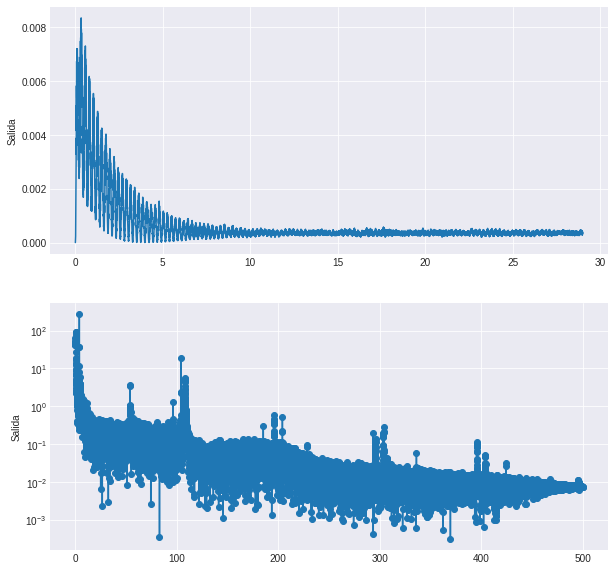

In [139]:
plt.figure(figsize=(10,10))
plt.clf()
fig, ax = plt.subplots(2,1,num=1)


# Filtrado de señal 
sos = signal.bessel(orden, 2*np.pi*fc, 'low', fs=Fs,output='sos') # Generación de parametros del filrado
PSDxFiltrada= signal.sosfilt(sos,PSDx) # Filtrado
PSDyFiltrada= signal.sosfilt(sos,PSDy) # Filtrado


## Para graficar R y theta
#ax[0].plot(t,np.arctan2(PSDyFiltrada,PSDxFiltrada,), label=r'$\theta$')
ax[0].plot(t,PSDxFiltrada**2+PSDyFiltrada**2,label='R') #ESTO TENEMOS QUE AJUSTAR
## Para graficar X e Y
#ax[0].plot(t,PSDxFiltrada,label='X')
#ax[0].plot(t,PSDyFiltrada,label='Y')
plt.legend(loc='lower right')
ax[0].set_ylabel('Salida'), ax[0].grid(True)


# 4 Grafica la FFT de la señal demodulada
fftPSDxFiltrada= np.abs(np.fft.fft(PSDxFiltrada));
fftPSDyFiltrada= np.abs(np.fft.fft(PSDyFiltrada));
ax[1].semilogy(freqs[0:L//2],fftPSDxFiltrada[0:L//2],'o-') 
ax[1].set_ylabel('Salida'),ax[1].grid(True)


A*x+B
A: -0.016527503445111145    B: -3.6470801024972817


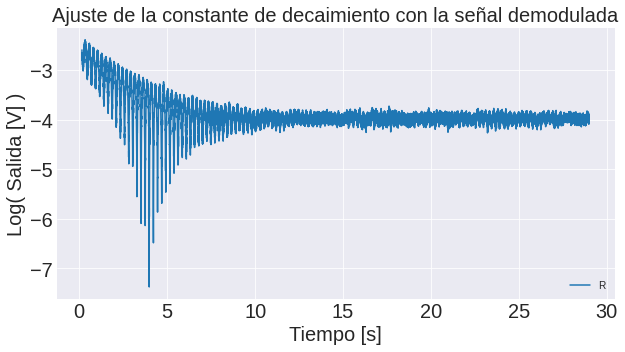

In [141]:
plt.figure(figsize=(10,5))

# Filtrado de señal 
sos = signal.bessel(orden, 2*np.pi*fc, 'low', fs=Fs,output='sos') # Generación de parametros del filrado
PSDxFiltrada= signal.sosfilt(sos,PSDx) # Filtrado
PSDyFiltrada= signal.sosfilt(sos,PSDy) # Filtrado
tdat=t[150:]
Rdat=np.log(np.sqrt(PSDxFiltrada**2+PSDyFiltrada**2))[150:]

## Para graficar R y theta
param = np.polyfit(tdat,Rdat,1)
mod = np.polyval(param,tdat)
print('A*x+B')
print('A:',param[0] , '   B:',param[1])
plt.plot(tdat,Rdat,label='R') #ESTO TENEMOS QUE AJUSTAR
#plt.plot(tdat, mod  ,'-', label='Ajuste')
## Para graficar X e Y
#ax[0].plot(t,PSDxFiltrada,label='X')
#ax[0].plot(t,PSDyFiltrada,label='Y')
plt.legend(loc='lower right')
plt.ylabel(r'Log( Salida [V] )',fontsize=20)
plt.xlabel(r'Tiempo [s]',fontsize=20)
plt.tick_params(axis="x", labelsize=20)
plt.tick_params(axis="y", labelsize=20)
plt.title("Ajuste de la constante de decaimiento con la señal demodulada",fontsize=20)
#plt.xticks(fontsize=13.5)
#plt.yticks(fontsize=13.5)

plt.savefig("AjusteLin Acero")